In [1]:
!pip install pandas numpy scikit-learn nltk matplotlib seaborn wordcloud joblib



Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')    

print("✅ All NLTK resources downloaded successfully!")



✅ All NLTK resources downloaded successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv("data/movie_reviews.csv")

if df['sentiment'].dtype == object:
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [3]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return ' '.join(text.split())

    def tokenize_and_lemmatize(self, text):
        tokens = word_tokenize(text)
        return ' '.join([self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words and len(t) > 2])

    def preprocess_text(self, text):
        return self.tokenize_and_lemmatize(self.clean_text(text))

# Preprocess text after downloading NLTK resources
preprocessor = TextPreprocessor()
df['cleaned_review'] = df['review'].apply(preprocessor.preprocess_text)
df[['review', 'cleaned_review', 'sentiment']].head()



,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching episode youll ...,1
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...,1


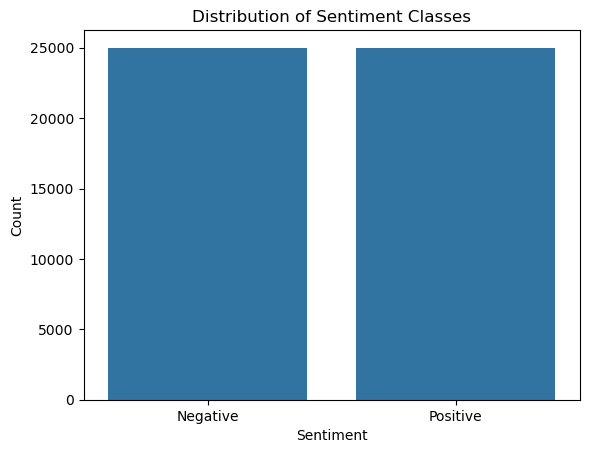

In [4]:

sns.countplot(data=df, x='sentiment')
plt.title("Distribution of Sentiment Classes")
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [5]:
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.95)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

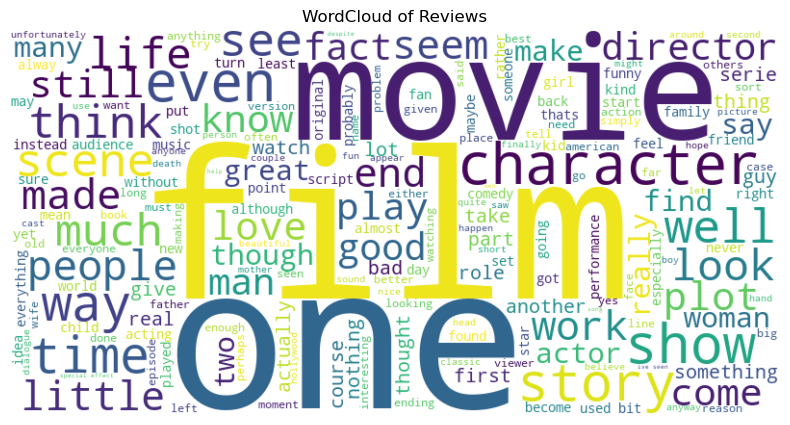

In [6]:

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_review']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Reviews")
plt.show()


In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

results


{'Logistic Regression': {'accuracy': 0.8911,
  'precision': 0.8836570531685305,
  'recall': 0.9008,
  'f1_score': 0.8921461820342677},
 'SVM': {'accuracy': 0.8929,
  'precision': 0.8842167025229807,
  'recall': 0.9042,
  'f1_score': 0.8940967072085435},
 'Random Forest': {'accuracy': 0.8531,
  'precision': 0.8573163327261688,
  'recall': 0.8472,
  'f1_score': 0.8522281460617644},
 'Naive Bayes': {'accuracy': 0.8595,
  'precision': 0.8482852160434025,
  'recall': 0.8756,
  'f1_score': 0.8617262080503887}}

Best Model: SVM
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



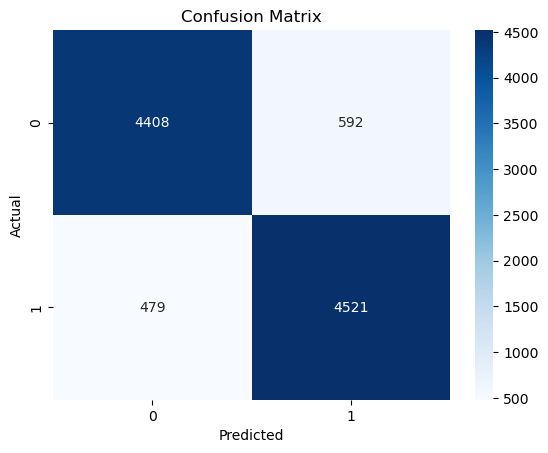

In [7]:
best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

y_pred = best_model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

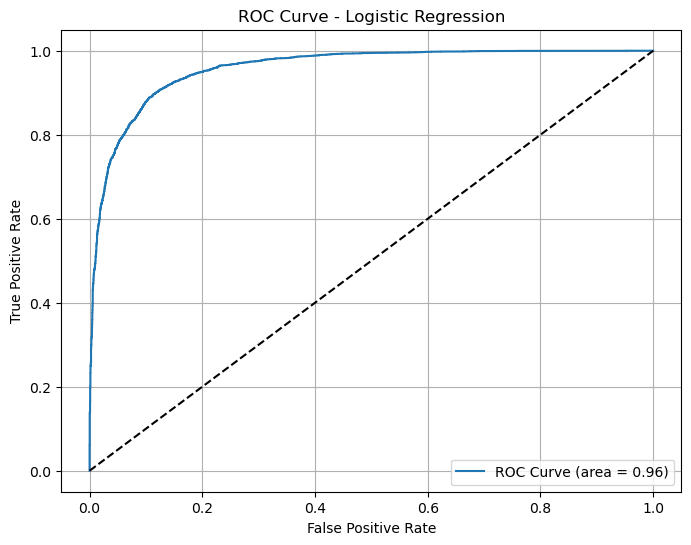

In [7]:

from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_probs = lr.predict_proba(X_test_vec)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [8]:
def predict_sentiment(text):
    cleaned = preprocessor.preprocess_text(text)
    vec = vectorizer.transform([cleaned])
    pred = best_model.predict(vec)[0]
    prob = best_model.predict_proba(vec)[0]
    sentiment = 'Positive' if pred == 1 else 'Negative'
    return {
        'review': text,
        'sentiment': sentiment,
        'confidence': round(max(prob), 4)
    }

# Test Prediction
predict_sentiment("Absolutely mind-blowing visuals and story.")

{'review': 'Absolutely mind-blowing visuals and story.',
 'sentiment': 'Positive',
 'confidence': 0.7797}

In [12]:
# Ensure the models folder exists
os.makedirs("models", exist_ok=True)

# Create a timestamped filename for each component
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"models/sentiment_model_{timestamp}.pkl"
vec_path = f"models/vectorizer_{timestamp}.pkl"

# Save only model and vectorizer
joblib.dump(best_model, model_path)
joblib.dump(vectorizer, vec_path)

print("✅ Model and vectorizer saved successfully.")
print(f"Model saved at: {model_path}")

✅ Model and vectorizer saved successfully.
Model saved at: models/sentiment_model_20250625_232109.pkl
